#  Mini-Projet : Détection de phonèmes par analyse du signal vocal


# Nom du ~~binôme :~~ solo: Nohé Hinniger-Foray

L'objectif de ce TP consiste à détecter et reconnaître les phonèmes  à partir de fichiers sonores au format *.wav* via l'analyse cepstrale.



Vous disposez d'une base d'apprentissage et une base de test. Il faut reconnaître tous les phénomènes suivants :
$$'a','e','e\_aigu','e\_grave','i','o','o\_ouvert','ou','u'$$


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

Comme chaque fichier a une durée différente, on calcule la moyenne des MFCC sur toutes les fenêtres de discrétisation. 

La matrice de sortie est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 13.

In [3]:
import librosa

In [4]:
# note: si erreur No module named 'pkg_resources' -> pip install setuptools
from os import listdir
from os.path import isfile, join
fichiers = [f for f in listdir("./Data/")]
sort_fichiers = sorted(fichiers)
DataMFCC=[]
label=[]
#print(sort_fichiers)

# Calcul des MFCC sur tous les fichiers de la base de données
for i in range(len(sort_fichiers)):
    # chargement du fichier audio
    y, sr = librosa.load("./Data/" + sort_fichiers[i])
    mfccBA = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=13)
    # Stockage et calcul du MFCC moyen pour le phonème
    DataMFCC.append(np.mean(mfccBA,axis=1))
    # Stockage de l'étiquette label
    label.append(i//10)

DataMFCC=np.asarray(DataMFCC)
label=np.asarray(label)
print('Dimension des données',DataMFCC.shape)
print(f"Nombre de fichiers: {len(sort_fichiers)}")
print(DataMFCC)

Dimension des données (90, 13)
Nombre de fichiers: 90
[[-238.0596      141.15851     -75.739265   ...  -10.300995
     6.364143     -0.9459904 ]
 [-298.5202      117.479645    -41.609333   ...   -1.1504037
    -1.5927106     3.7178125 ]
 [-303.79373     135.18707     -45.530872   ...   -4.453291
     5.7794333     0.55144626]
 ...
 [-379.03082      76.082344    -17.468042   ...  -15.718434
   -12.745434      3.3831096 ]
 [-358.20218      78.10892     -22.497774   ...  -10.208518
   -15.719375    -11.261739  ]
 [-360.6201       99.35901     -19.13921    ...    2.9860082
    -2.59352     -25.336243  ]]


In [5]:
# Phonème associé à chaque valeur de label
# Nomlabel=['a','e','e\_aigu','e\_grave','i','o','o\_ouvert','ou','u'] 
Nomlabel=['a','e','e_aigu','e_grave','i','o','o_ouvert','ou','u'] 

In [6]:
# Description des données 
unique, counts = np.unique(label, return_counts=True)


for i in range(unique.shape[0]):
    print('Label',unique[i],'correspond à ',Nomlabel[i],':',counts[i],'enregistrements');

Label 0 correspond à  a : 10 enregistrements
Label 1 correspond à  e : 10 enregistrements
Label 2 correspond à  e_aigu : 10 enregistrements
Label 3 correspond à  e_grave : 10 enregistrements
Label 4 correspond à  i : 10 enregistrements
Label 5 correspond à  o : 10 enregistrements
Label 6 correspond à  o_ouvert : 10 enregistrements
Label 7 correspond à  ou : 10 enregistrements
Label 8 correspond à  u : 10 enregistrements


###  Découpage de l'ensemble de données en Apprentissage et test pour les approches supevisée. 

In [7]:
# Séparation de l'ensemble de données en Base d'apprentissage et base de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DataMFCC, label, random_state=0,test_size=0.2)

print('Dimension Base d apprentissage :', X_train.shape)
print('Dimension Base de test :', X_test.shape)

Dimension Base d apprentissage : (72, 13)
Dimension Base de test : (18, 13)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [8]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros(len(np.unique(cluster_labels)))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred,label):
  # Correspondance entre la partition du clusterin y_pred et les classes de la vérité terrain label
  reference_labels = retrieve_info(y_pred,label)
  number_labels = np.zeros(len(y_pred))
  for i in range(len(y_pred)):
    number_labels[i] = reference_labels[y_pred[i]]
  return number_labels


# Partie I : Classification des phonèmes sans prétraitement 

Réaliser une classification de ces phonèmes par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser le triangle voyellique présenté ci-après pour interpréter les résultats.

## Méthode supervisée  : Classification Bayesienne


accuracy score: 1.0


Text(0.5, 58.7222222222222, 'predicted label')

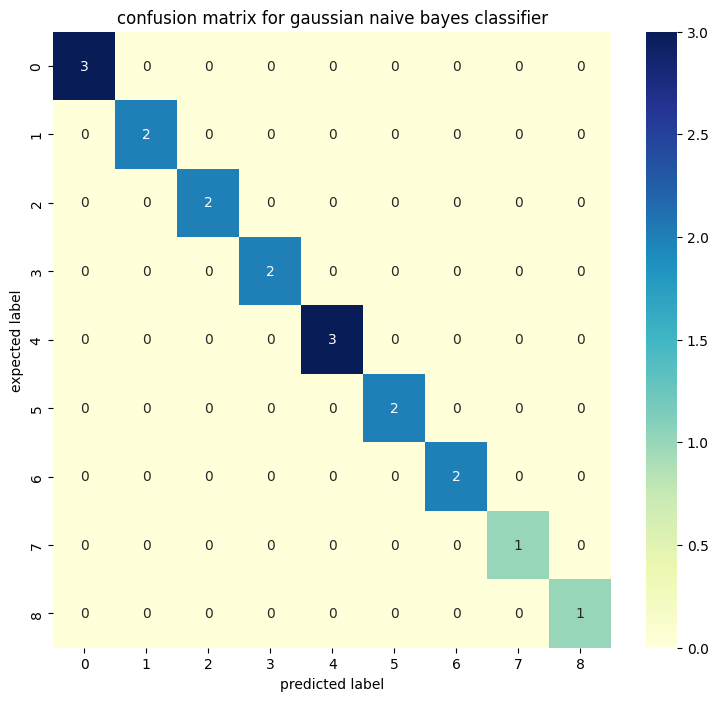

In [9]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
# On choisit gaussian plutot que multinomial car la donnée est discrete (multinomial est adapté a compter des occurences par ex)
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
fit = classifier.fit(X_train, y_train)

y_predicted = classifier.predict(X_test)

# on compare les predictions avec le jeu de test
score = accuracy_score(y_test, y_predicted)
print(f"accuracy score: {score}")

cm = confusion_matrix(y_true=y_test, y_pred=y_predicted)
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title('confusion matrix for gaussian naive bayes classifier')
plt.ylabel("expected label")
plt.xlabel("predicted label")

In [10]:
cm_sum_ponderate_sum = cm / cm.size 


## Méthode non supervisée : K-Means

using KMeans with 9 clusters
accuracy score: 0.7666666666666667


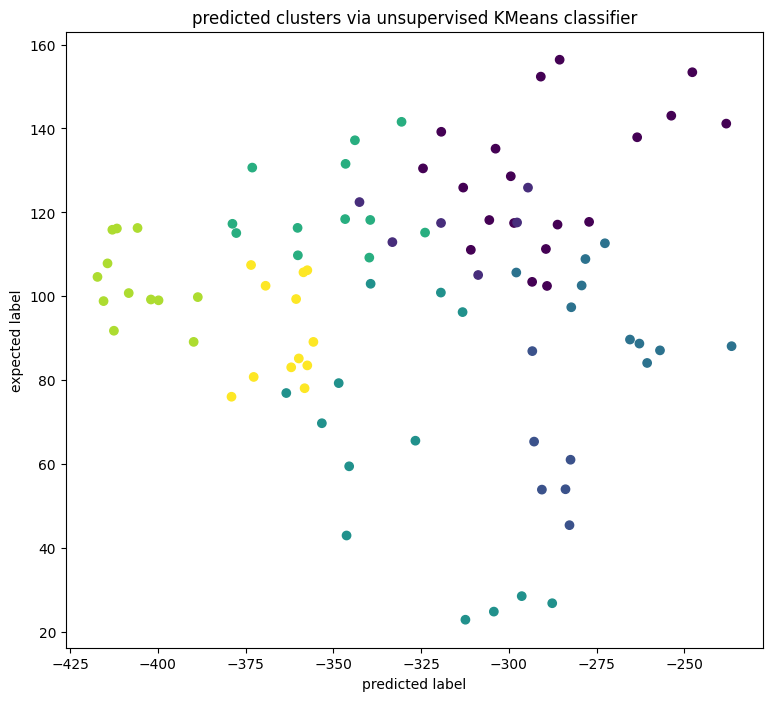

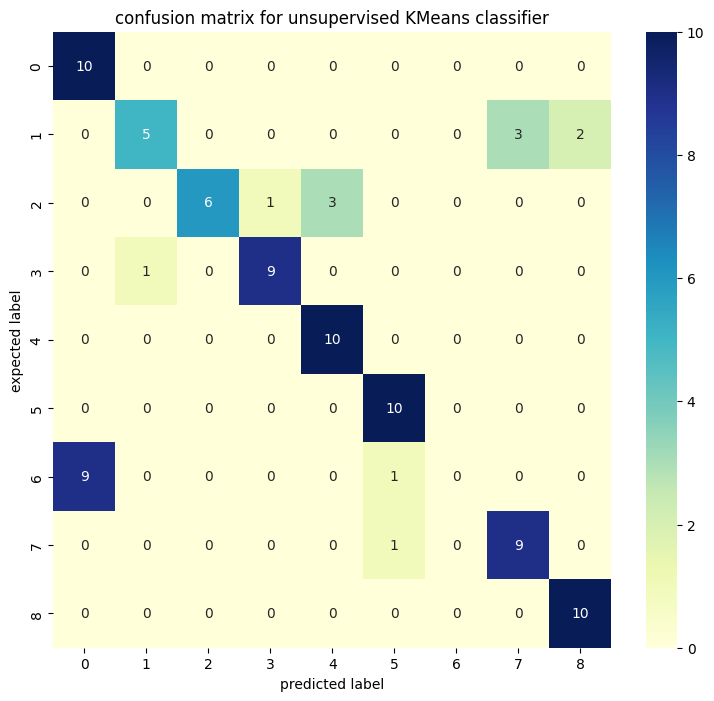

In [11]:
# https://scikit-learn.org/stable/modules/naive_bayes.html
# On choisit gaussian plutot que multinomial car la donnée est discrete (multinomial est adapté a compter des occurences par ex)
from sklearn.cluster import KMeans

n_clusters = len(Nomlabel) 
print(f"using KMeans with {n_clusters} clusters")

classifier = KMeans(n_clusters=n_clusters)
# On fit sur l'intégralité de la data (non supervisé)
y_predicted = classifier.fit_predict(DataMFCC)

# On associe les clusters k_means au labels (de façon a maximiser l'accuracy)
y_predicted_labelized = correspondance(y_predicted, label)

# on compare les predictions avec le jeu de test
score = accuracy_score(label, y_predicted_labelized)
print(f"accuracy score: {score}")

# Affichage des clusters
# Peu représentatif car en 2D, sur les deux premiers MFCC, on en extrait 13 en réalité
plt.figure(figsize=(9, 8))
plt.scatter(DataMFCC[:, 0], DataMFCC[:, 1], c=y_predicted_labelized)
plt.title("predicted clusters via unsupervised KMeans classifier")
plt.ylabel("expected label")
plt.xlabel("predicted label")

# Confusion matrix
cm = confusion_matrix(y_true=label, y_pred=y_predicted_labelized)
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title('confusion matrix for unsupervised KMeans classifier')
plt.ylabel("expected label")
plt.xlabel("predicted label")

cm_sum_ponderate_sum += cm / cm.size 

# TODO idea: fit n fois et calculer une moyenne d'accuracy et confustion matrix + best + worse

## Méthode non supervisée 2 : Spectral clustering

# Partie II : classification des phonèmes avec prétraitement 


## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)




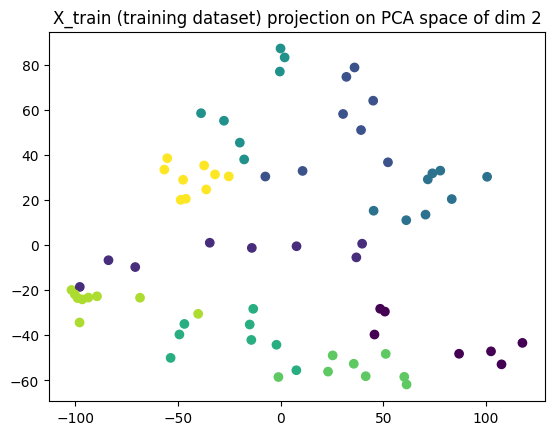

accuracy score: 0.8333333333333334


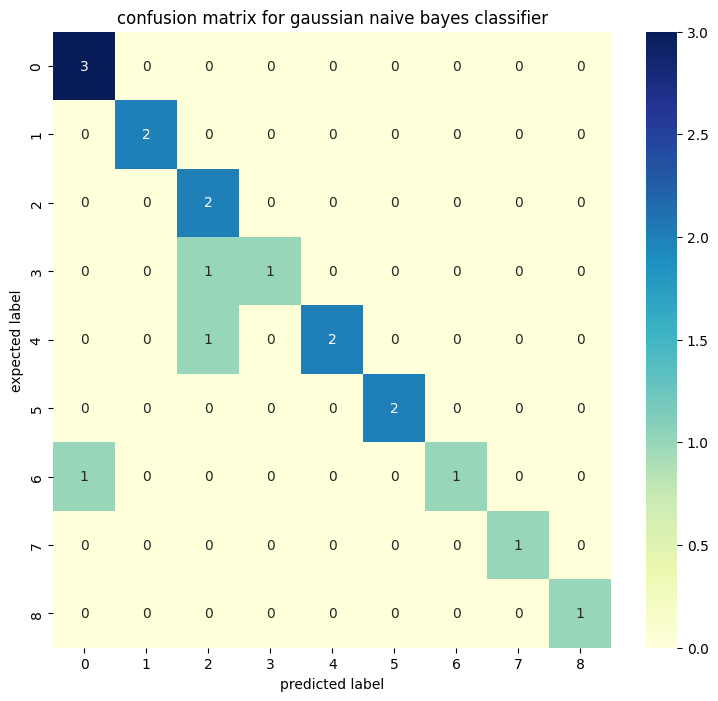

In [12]:
from sklearn.decomposition import PCA
dim=2
pca = PCA(dim)
X_train_projection = pca.fit_transform(X_train)
plt.scatter(X_train_projection[:, 0], X_train_projection[:, 1],marker='o', c=y_train)
plt.title(f"X_train (training dataset) projection on PCA space of dim {dim}")
plt.show()

classifier = GaussianNB()
fit = classifier.fit(X_train_projection, y_train)

X_test_projection=pca.transform(X_test)
y_predicted = classifier.predict(X_test_projection)

# on compare les predictions avec le jeu de test
score = accuracy_score(y_test, y_predicted)
print(f"accuracy score: {score}")

cm = confusion_matrix(y_true=y_test, y_pred=y_predicted)
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title('confusion matrix for gaussian naive bayes classifier')
plt.ylabel("expected label")
plt.xlabel("predicted label")

cm_sum_ponderate_sum += cm / cm.size 


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données 

Réaliser une ACP sur l'ensemble des données et indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

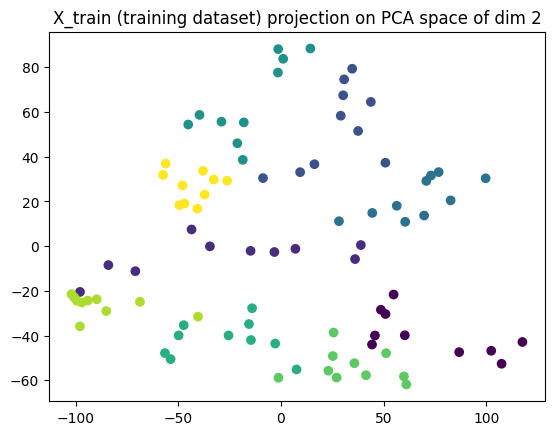

accuracy score: 0.6888888888888889


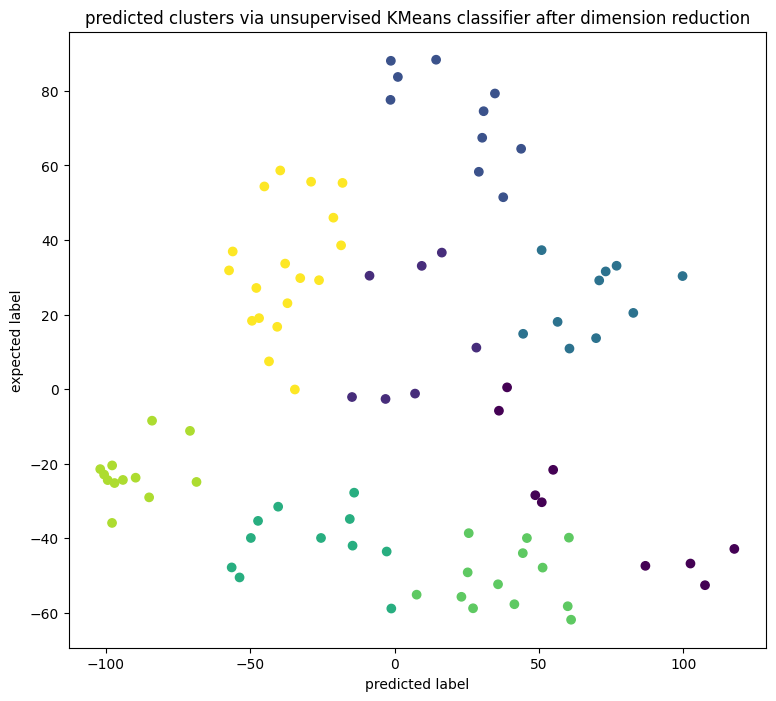

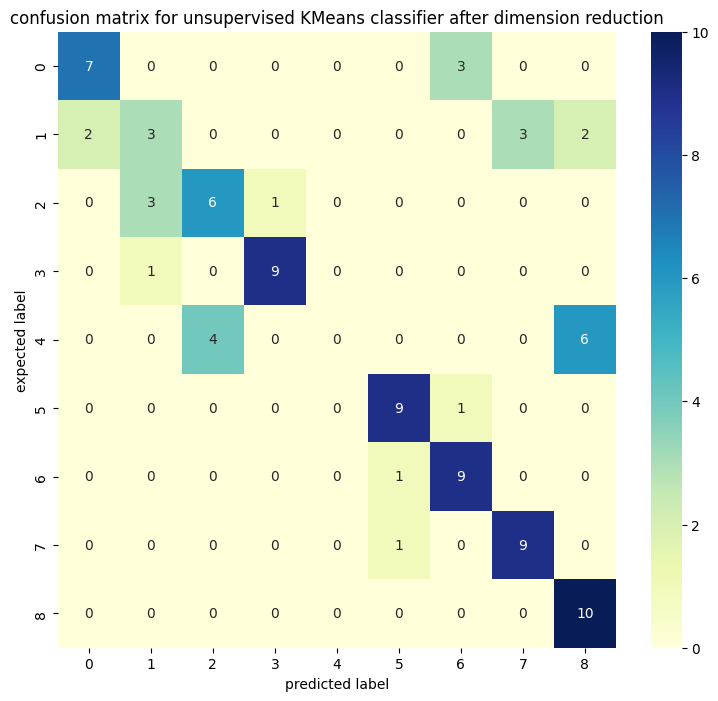

In [13]:
from sklearn.decomposition import PCA
dim=2
pca = PCA(dim)
Data_projection = pca.fit_transform(DataMFCC)
plt.scatter(Data_projection[:, 0], Data_projection[:, 1],marker='o', c=label)
plt.title(f"X_train (training dataset) projection on PCA space of dim {dim}")
plt.show()

classifier = KMeans(n_clusters=n_clusters)
# On fit sur l'intégralité de la data projetée (non supervisé)
y_predicted = classifier.fit_predict(Data_projection)

# On associe les clusters k_means au labels (de façon a maximiser l'accuracy)
y_predicted_labelized = correspondance(y_predicted, label)

# on compare les predictions avec le jeu de test
score = accuracy_score(label, y_predicted_labelized)
print(f"accuracy score: {score}")

# Affichage des clusters
# Peu représentatif car en 2D, sur les deux premiers MFCC, on en extrait 13 en réalité
plt.figure(figsize=(9, 8))
plt.scatter(Data_projection[:, 0], Data_projection[:, 1], c=y_predicted_labelized)
plt.title("predicted clusters via unsupervised KMeans classifier after dimension reduction")
plt.ylabel("expected label")
plt.xlabel("predicted label")

# Confusion matrix
cm = confusion_matrix(y_true=label, y_pred=y_predicted_labelized)
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.title('confusion matrix for unsupervised KMeans classifier after dimension reduction')
plt.ylabel("expected label")
plt.xlabel("predicted label")

X_test_projection=pca.transform(X_test)
y_predicted = classifier.predict(X_test_projection)

cm_sum_ponderate_sum += cm / cm.size 

### Recherche de la meilleure dimension

dim = 2 à été choisi arbitrairement (et car utile pour représenter la donnée sur une image), mais on peut alors se poser la question: quelle et la réduction idéale pour la méthode non supervisée KMeans (on pourrait aussi tester avec la méthode supervisée) ?

Methodologie: comme KMeans est non déterministe (on obtiens un score qui varie a chaque run) je fit n_fit fois par dimension (dim) et je garde le score moyen.

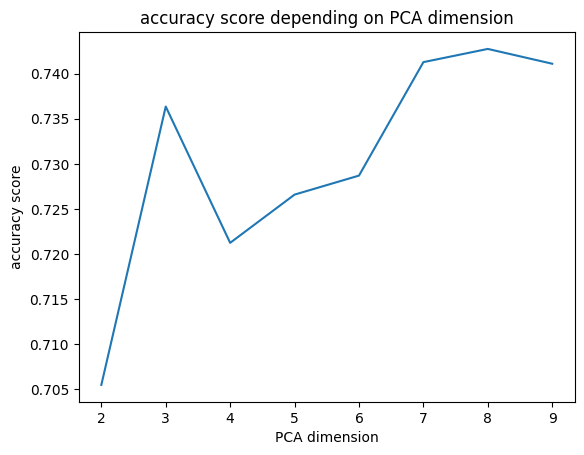

In [30]:
def pca_to_dim(dim):
    if dim == len(Nomlabel):
        return DataMFCC
    pca = PCA(dim)
    return pca.fit_transform(DataMFCC)

def n_kmeans_avg_score(n_fit, data, label):
    scores = []
    for _ in range(n_fit):
        classifier = KMeans(n_clusters=n_clusters)
        y_predicted = classifier.fit_predict(data)
        y_predicted_labelized = correspondance(y_predicted, label)
        score = accuracy_score(label, y_predicted_labelized)
        scores.append(score)
    return np.mean(scores)

dims = [2, 3, 4, 5, 6, 7, 8, 9]
n_fit = 500
scores = [n_kmeans_avg_score(n_fit, pca_to_dim(dim), label) for dim in dims]
plt.plot(dims, scores)
plt.title("accuracy score depending on PCA dimension")
plt.ylabel("accuracy score")
plt.xlabel("PCA dimension")
plt.show()


Il semble y avoir une tendance pour laquelle l'accuracy score augmente avec la dimension de la PCA, mais cela n'est pas toujours vrai.
dim = 3 semble aussi efficace. La réduction à 8 dimensions est plus performante que pas de réduction (9 dimensions).

### Recherche de la meilleure reduction de dimension (méthode supervisée)

Je répete le meme procédé (par curiosité), sur la méthode supervisée (GaussianBayesian)

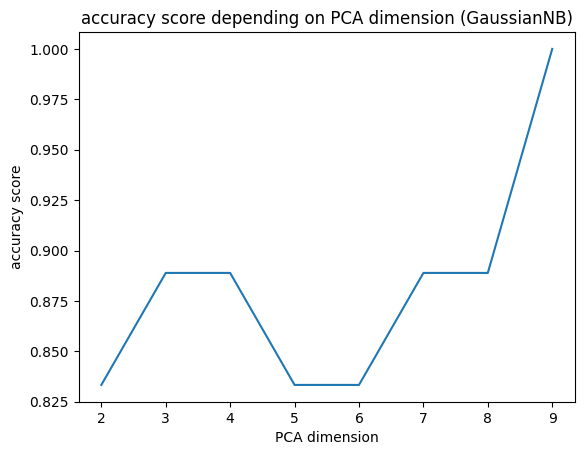

In [29]:
def pca_to_dim(dim):
    if dim == len(Nomlabel):
        return X_train, X_test
    pca = PCA(dim)
    train = pca.fit_transform(X_train)
    test = pca.transform(X_test)
    return train, test

def gaussian_score(dim):
    train, test = pca_to_dim(dim)
    classifier = GaussianNB()
    fit = classifier.fit(train, y_train)
    y_predicted = fit.predict(test)
    return accuracy_score(y_test, y_predicted)

scores = [gaussian_score(dim) for dim in dims]
plt.plot(dims, scores)
plt.title("accuracy score depending on PCA dimension (GaussianNB)")
plt.ylabel("accuracy score")
plt.xlabel("PCA dimension")
plt.show()



On voit un pattern étonnant ici, entre 3 et 7. On voit aussi que sans réduction la prédiction est bien meilleure. On peut donc s'intérroger sur l'intéret de la projection PCA ?

## Partie III : Analyse des résultats 

En compilant toutes les matrices de confusion en une seule, (en effectuant une moyenne pondéré des matrices), et que l'on ignore la diagonale on obtient une matrice représentant les erreurs et leur fréquence.

Text(0.5, 58.7222222222222, 'predicted label')

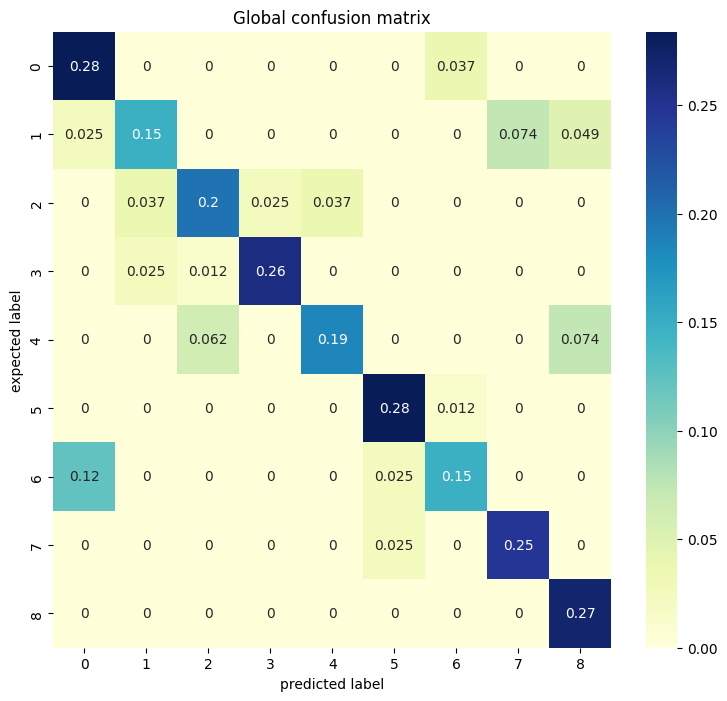

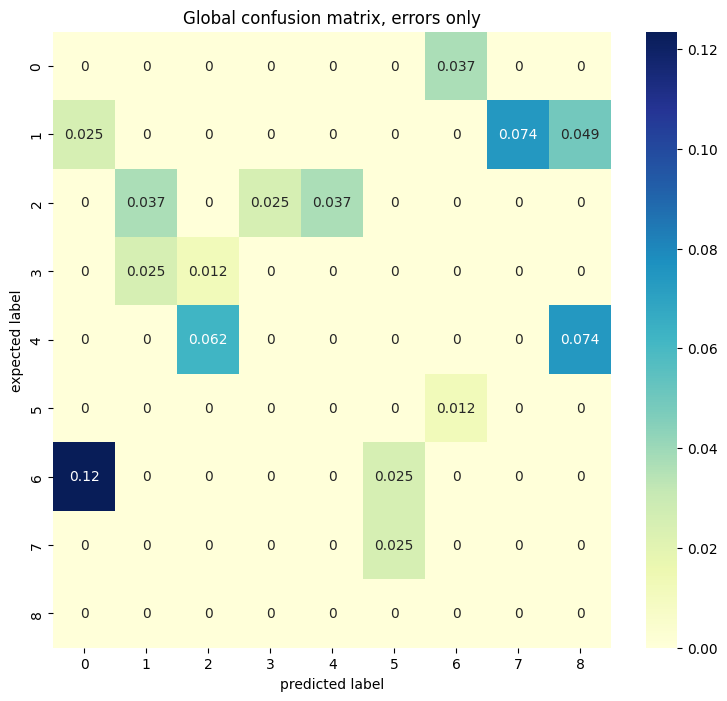

In [15]:
plt.figure(figsize=(9, 8))
sns.heatmap(cm_sum_ponderate_sum, annot=True, cmap="YlGnBu")
plt.title('Global confusion matrix')
plt.ylabel("expected label")
plt.xlabel("predicted label")

gcm_errors = cm_sum_ponderate_sum.copy()
np.fill_diagonal(gcm_errors, 0)

plt.figure(figsize=(9, 8))
sns.heatmap(gcm_errors, annot=True, cmap="YlGnBu")
plt.title('Global confusion matrix, errors only')
plt.ylabel("expected label")
plt.xlabel("predicted label")



<img src="triangle_voyellique.jpg" width="600" height="600"  >

In [16]:
# errors list(expected, predicted, freq) sorted by frequency
errors = []
for i in range(gcm_errors.shape[0]):
  for j in range(gcm_errors.shape[1]):
    if gcm_errors[i, j] > 0:
      errors.append((i, j, gcm_errors[i, j]))

errors = sorted(errors, key=lambda x: x[2], reverse=True)

# Errors mapped to label names
errors_mapped = [(Nomlabel[i], Nomlabel[j], freq) for i, j, freq in errors]

# Pretty display of errors 
for i, j, freq in errors_mapped:
  print(f"Expected: {i}, predicted: {j}, frequency: {freq}")

Expected: o_ouvert, predicted: a, frequency: 0.12345679012345678
Expected: e, predicted: ou, frequency: 0.07407407407407407
Expected: i, predicted: u, frequency: 0.07407407407407407
Expected: i, predicted: e_aigu, frequency: 0.06172839506172839
Expected: e, predicted: u, frequency: 0.04938271604938271
Expected: a, predicted: o_ouvert, frequency: 0.037037037037037035
Expected: e_aigu, predicted: e, frequency: 0.037037037037037035
Expected: e_aigu, predicted: i, frequency: 0.037037037037037035
Expected: e, predicted: a, frequency: 0.024691358024691357
Expected: e_aigu, predicted: e_grave, frequency: 0.024691358024691357
Expected: e_grave, predicted: e, frequency: 0.024691358024691357
Expected: o_ouvert, predicted: o, frequency: 0.024691358024691357
Expected: ou, predicted: o, frequency: 0.024691358024691357
Expected: e_grave, predicted: e_aigu, frequency: 0.012345679012345678
Expected: o, predicted: o_ouvert, frequency: 0.012345679012345678


On voit que les erreurs sont proches sur le triangle voyellique, et souvent plutot dans l'axe vertical.